# Capstone Project: Recommender for Local Coffee-Drinking Places
    (Data obtained from Yelp)
    (Author: Mr Jason Chia)

## Background and Business Problem
---

- It is ever more challenging nowadays to decide on a prime spot for one's favorite cuppa coffee against the backdrop of a burgeoning food and beverage industry (FnB). With the younger generation rising to the occasion in recent years, we are seeing an increasing number of artisanal and creative FnB outlets, touting all sorts of innovative menu items that render the typical coffee consumers like you utterly spoilt for choice! Beyond these new up-and-coming outfits, don't forget the idyllic, quaint but ultimately good testaments to quality coffee such as traditional hawker centres and foodcourts - there are definitely more than one too many options for coffee-drinkers who prefer to pander to old times and nostalgia too!


## Overview of Recommendation Systems and Project Objective
---

- Therefore, I am taking it upon myself to make your life that much easier by building a recommendation system that will recommend you coffee-drinking places based on reviews and ratings! So instead of poring over all outlets' reviews and checking out their individual ratings on Yelp one by one until one reaches the 1000th outlet before deciding which to settle for, users can potentially just rate a couple that they have been to before, click another button, and BAM!...Out comes the top 5 recommendations you can check out right away!


- Types of recommendation systems include Collaborative Filtering - where a user's preferences are predicted from other similar users' and hence, the collaborative aspect, and ranking preference predictions in the form of rating predictions for example, to generate recommendations - and Content-based Filtering - where a user is recommended items similar in terms of item characteristics such as item category to the items once liked or rated highly by user. Collaborative Filtering allows the possibility of cross-recommendations - where items dissimilar to an item once liked or rated highly by user could be recommended to user based on high ratings by other users of similar tastes - but faces the cold-start problem - hard to predict preferences of new users who have never rating anything before or recommend new items that have not been rated before by users. Collaborative Filtering can be sub-divided further into Memory-based and Model-based. [Memory-based Collaborative Filtering](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101) is purely based on determining similarities between different users' preferences based on past users' rating patterns using some form of pairwise distance metric such as Jaccard distance metric or cosine similarity, while Model-based Collaborative Filtering relies upon an algorithm to model user-item interactions and thus has slightly higher bias but will generalize better to out-of-sample data and hence have lower variance. An example of a model-based collaborative filtering algorithm is the Alternating Least Squares (ALS) algorithm which is a matrix factorization technique that decomposes user-item interaction matrix (such as user-item ratings matrix for datasets with explicit feedback) into user and item latent factors where their dot product will predict user ratings. It alternates between fixing user or item latent factors to solve for the other via gradient descent at each iteration in the process of minimizing loss:
    
    
<img src="yelp_data/matfact_explain.png"/>


- [User-centered Content-based Filtering](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada) is about building a model for each user that predicts that user's rating for all the different items based on characteristics of the various items such as item category, item review count etc., in the process, learning that user's coefficients. A potential shortfall of Content-based Filtering is that it is unlikely to provide cross-recommendations - something that can be compensated by Collaborative Filtering in a hybrid recommendation system which will be what I will be building in this project, albeit a simple version... 


- Ideally, there should be one model built for each user in content-based filtering but for the purpose of a simple demonstration in this capstone project of 6-7 weeks, I will only be building and tuning one model for the user-centered content-based filtering component for the hybrid system for a sample user (userid 2043) who happened to have rated a vast majority of the coffee-drinking outlets contained within the dataset to be used for this project. Now this could potentially introduce bias since the content-based model will only be representative of this particular user's taste and preferences but we will see later on that's where a hybrid recommendation system's value shines through, with the collaborative filtering component compensating for this bias since it takes into account other similar users' ratings. 


## Process
---

- Data scraping: The data is a list of 987 coffee drinking places in Singapore scraped using Yelp's api token, 6,292 reviews, 7,076 ratings and userids of reviews scraped using BeautifulSoup from Yelp's website.


- Data Cleaning, Feature Engineering, Preprocessing, and Exploratory Data Analysis (EDA)


- Content-based Filtering and Evaluation (Micro-Average Precision, Recall, $F_1$, ROC AUC, and Prevalence-Weighted ROC AUC) (details inside Parts 2 - 6 notebooks): 
    1. Modeling with Logistic Regression and Tfidf vectorization
    2. Modeling with Logistic Regression and Tfidf vectorization and PCA
    3. Modeling with Decision Tree Classifier and Tfidf vectorization (performed best)
    4. Modeling with Decision Tree Classifier and Tfidf vectorization and PCA
    5. Modeling with Random Forest Classifier and Tfidf vectorization
    

- Collaborative Filtering with ALS and Evaluation (Micro-Average Precision, Recall, $F_1$) (details inside Part 7 notebook)


- Hybrid Recommendation System Evaluation (Micro-Average Precision, Recall, $F_1$) (details inside Part 8 notebook)
    1. Combination of Content-based and Collaborative Filtering by taking weighted sum of ratings from both as the final rating predictions


- Simple Trial of Hybrid Recommendation System : 10 arbitrary ratings will be fed into the system to see if it works to churn out discernible recommendations (details inside Part 9 notebook)


- Model Limitations and Potential Improvements (details inside Part 9 notebook)


- Conclusions and Future Plans (details inside Part 9 notebook)


## Milestones
---

- Milestone 1: Build User-Centered Content-based Filtering using a sample userid 2043 who has rated a vast majority of outlets using a supervised machine learning model (done)


- Milestone 2: Build Model-based Collaborative Filtering using pyspark's ALS algorithm that is primed for collaborative filtering recommendation systems (done)


- Milestone 3: Combine both Content-based and Collaborative Filtering into a hybrid system by weighting their respective predictions based on their tuned models' F1 scores to generate final user rating predictions for evaluation (done)


- Milestone 4: Conduct a mini trial by posing as a user and feeding 10 arbitrary ratings into the hybrid system to generate recommendations (done)


- Long-term goals beyond capstone presentation: Deployment tasks using Flask and Heroku (TBD)

## Data Scraping, Cleaning, Feature Engineering, Preprocessing, and Exploratory Data Analysis (EDA)
---

- Importing relevant libraries first:

In [1]:
#!pip install wordcloud

In [142]:
#import requests
import random
#import time
import numpy as np
import pandas as pd
#from bs4 import BeautifulSoup as bs
import re
from sklearn.preprocessing import LabelEncoder
#from os import path   #uncomment these if you have downloaded and installed wordcloud based on the instructions above
#from PIL import Image
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
#from imblearn.over_sampling import ADASYN
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [143]:
#api_key = 'Vj_pNA3PAEMJnJ-Lxl-bHMYyre0RobZbTB5LVI3L3SE17vAZi-jH6Db0ZVHEwztlpFVefzT85W6emToeEk259xX2dxAbJhgd1FSOW4gZBlBaCGO3-YacNG-0HOptXnYx'

In [144]:
#end_point = 'https://api.yelp.com/v3/businesses/search'

In [145]:
#headers = {'Authorization': 'bearer %s' % api_key}

In [146]:
#coffee_places_sg = []
#for i in range(50):
 #   parameters_sg = {'term':'coffee',
  #                'limit':50,
   #               'radius':10000,
    #              'offset':i*50,
     #             'location':'Singapore'}

#    response_sg = requests.get(url=end_point,params=parameters_sg,headers=headers)
 #   business_search_sg = response_sg.json()
    
  #  try:
   #     [biz for biz in business_search_sg['businesses']] 
   # except:
    #    print("no more businesses to be scraped!")
     #   break
  #  coffee_places_sg.extend([biz for biz in business_search_sg['businesses']])
  #  pd.DataFrame(coffee_places_sg).to_csv('yelp_data/coffee_places_sg.csv',index=False)
  #  print("{} sg coffee places scraped!".format(len(coffee_places_sg)))
  #  sleep_duration = random.randint(120,240)
  #  print(sleep_duration)
  #  time.sleep(sleep_duration)

In [147]:
#reading in the scraped preliminary dataset sans the reviews and user ratings...
df = pd.read_csv('yelp_data/coffee_places_sg.csv') 
df.head(3)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,NcgdacFqZtFllBrJQglcPQ,nylon-coffee-roasters-singapore,Nylon Coffee Roasters,https://s3-media2.fl.yelpcdn.com/bphoto/LV3F1g...,False,https://www.yelp.com/biz/nylon-coffee-roasters...,70,"[{'alias': 'coffeeroasteries', 'title': 'Coffe...",4.5,"{'latitude': 1.276809987029, 'longitude': 103....",[],$,"{'address1': '4 Everton Park', 'address2': '# ...",6.562202e+09,+65 6220 2330,4267.253090
1,qjF6uy-z3JsBKLPM0Uq-bQ,common-man-coffee-roasters-singapore,Common Man Coffee Roasters,https://s3-media2.fl.yelpcdn.com/bphoto/BozNK4...,False,https://www.yelp.com/biz/common-man-coffee-roa...,83,"[{'alias': 'coffeeroasteries', 'title': 'Coffe...",4.0,"{'latitude': 1.29186, 'longitude': 103.83842}",[],$$,"{'address1': '22 Martin Rd', 'address2': '#01-...",6.568365e+09,+65 6836 4695,2737.905606
2,E1bWrjBJDrHUKqzu3SPt3w,tolidos-espresso-nook-singapore-3,Tolido's Espresso Nook,https://s3-media2.fl.yelpcdn.com/bphoto/cu45w5...,False,https://www.yelp.com/biz/tolidos-espresso-nook...,64,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"{'latitude': 1.30453486052728, 'longitude': 10...",[],$$,"{'address1': '462 Crawford Ln', 'address2': '#...",6.566480e+09,+65 6648 0178,1717.887930


In [148]:
#aliases_sg = list(set(df['alias'].tolist()))

<ul> 
    
- The above used an API token from Yelp to scrape data to see what preliminary info I could get. The ```aliases_sg``` variable was then derived from the preliminary info (```df```) to scrape the userids, user reviews and ratings, using ```BeautifulSoup```, which are not obtainable using the API token - the token only allows scraping 3 reviews per outlet... 

</ul>

In [149]:
#new code; caveat - some stores may have updated and past reviews and ratings provided by the same user.
#sg_store_rev = {} #to scrape reviews from sg coffee places 
#sg_store_rating = {} #to scrape ratings from sg coffee places; 
#sg_store_userid = {} #to scrape userids for reviews and ratings from sg coffee places
#outlet_count = 0
#for alias in aliases_sg:
    #count = 0
    #sg_url = "https://www.yelp.com/biz/{}?osq=coffee".format(alias)
    #print(sg_url)
    #sg_store = requests.get(sg_url)
    #sg_store_soup = bs(sg_store.content, 'lxml')
    #if sg_store_soup.find_all('span',{'itemprop':'reviewCount'}) ==[]:
        #print(alias, "no reviews")
        #outlet_count += 1
        #print("{} stores out of {} stores done!".format(outlet_count,len(aliases_sg)))
        #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rev.items()}).to_csv('yelp_data/sg_store_rev.csv', index=False)
        #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rating.items()}).to_csv('yelp_data/sg_store_rating.csv', index=False)
        #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_userid.items()}).to_csv('yelp_data/sg_store_userid.csv', index=False)
        #sleep_duration = random.randint(15,50)
        #print("Resting {} seconds...".format(sleep_duration))
        #print(" ")
        #time.sleep(sleep_duration)
        #continue
    #else:
        #next_url = sg_url + "&start=" + str(count+20)
        #print("Checking to see if next page for this store {} has any reviews and ratings to scrape...".format(next_url))
        #print(" ")
        #sg_store_next_url = next_url
        #sg_store_next_page = requests.get(sg_store_next_url)
        #sg_store_next_page_soup = bs(sg_store_next_page.content, 'lxml')
        #if [tag.text for tag in sg_store_next_page_soup.find_all('span',{'lang':'en'})] == []:
            #print("Nope! This store only has 1 page of reviews and ratings to be scraped! Let's go!")
            #print(" ")
            #if [tag.text for tag in sg_store_soup.find_all('span',{'lang':'en'})] == []:
                #print("But...there are no english reviews...so let's move on!")
                #sg_store_reviews = []
                #sg_store_ratings = []
                #sg_store_userids = []
                #sg_store_rev[alias] = sg_store_reviews
                #sg_store_rating[alias] = sg_store_ratings
                #sg_store_userid[alias] = sg_store_userids
                #print("Store {} has {} english reviews".format(alias,len(sg_store_reviews)))
                #print(" ")
                #outlet_count += 1
                #print("{} stores out of {} stores done!".format(outlet_count,len(aliases_sg)))
                #print(" ")
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rev.items()}).to_csv('yelp_data/sg_store_rev.csv', index=False)
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rating.items()}).to_csv('yelp_data/sg_store_rating.csv', index=False)
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_userid.items()}).to_csv('yelp_data/sg_store_userid.csv', index=False)
                #sleep_duration = random.randint(15,50)
                #print("Resting {} seconds...".format(sleep_duration))
                #print(" ")
                #time.sleep(sleep_duration)
                #continue
            #else:
                #sg_store_reviews = [tag.text for tag in sg_store_soup.find_all('span',{'lang':'en'})]
              #  print("First review of page: {}".format(sg_store_reviews[0]))
              #  print(" ")
                #sg_store_ratings = [tag.attrs['aria-label'] for tag in sg_store_soup.find_all('div',{'aria-label':re.compile('[0-9] star rating')})[1:len(sg_store_reviews)+1]]
              #  print("First rating of page: {}".format(sg_store_ratings[0]))
              #  print(" ")
                #atags = sg_store_soup.find_all('a', href = re.compile('\/user_details\?userid=\w+'))
                #userids = []
                #for tag in atags:
                    #m = re.search('userid=(\w+)', str(tag))
                    #userids.append(m.group()[7:])
                #sg_store_userids = userids[::2]
                #sg_store_rev[alias] = sg_store_reviews
                #sg_store_rating[alias] = sg_store_ratings
                #sg_store_userid[alias] = sg_store_userids
                #print("Store with 1 page of reviews and ratings {} has {} reviews".format(alias,len(sg_store_reviews)))
                #print(" ")
                #print("Store with 1 page of reviews and ratings {} has {} ratings".format(alias,len(sg_store_ratings)))
                #print(" ")
                #print("Store with 1 page of reviews and ratings {} has {} userids".format(alias,len(sg_store_userids)))
                #print(" ")
                #outlet_count += 1
                #print("{} stores out of {} stores done!".format(outlet_count,len(aliases_sg)))
                #print(" ")
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rev.items()}).to_csv('yelp_data/sg_store_rev.csv', index=False)
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rating.items()}).to_csv('yelp_data/sg_store_rating.csv', index=False)
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_userid.items()}).to_csv('yelp_data/sg_store_userid.csv', index=False)
                #sleep_duration = random.randint(15,50)
                #print("Resting {} seconds...".format(sleep_duration))
                #print(" ")
                #time.sleep(sleep_duration)
                #continue
        #else:
            #print("Next page got! But first, extracting from 1st page first:", sg_url)
            #print(" ")
            #sg_store_reviews = []
            #sg_store_ratings = []
            #sg_store_userids = []
            #if [tag.text for tag in sg_store_soup.find_all('span',{'lang':'en'})] == []:
                #print("No english reviews on this page, looking at next page..")
                #while [tag.text for tag in sg_store_next_page_soup.find_all('span',{'lang':'en'})] != []:
                    #count += 20
                    #print("Count is currently: {}".format(count))
                    #print(" ")
                    #sg_store_next_url = sg_url + '&start=' + str(count)
                    #print("New current page to scrape is {}".format(sg_store_next_url))
                    #print(" ")
                    #sg_store_next_page = requests.get(sg_store_next_url)
                    #sg_store_next_page_soup = bs(sg_store_next_page.content, 'lxml')
                    #sg_store_next_page_reviews = [tag.text for tag in sg_store_next_page_soup.find_all('span',{'lang':'en'})]
                    #print("Number of reviews on new current page: {}".format(len(sg_store_next_page_reviews)))
                    #print(" ")
                #    print("First review of page: {}".format(sg_store_next_page_reviews[0]))
                #    print(" ")
                    #sg_store_reviews.extend(sg_store_next_page_reviews)
                    #print("Number of reviews scraped up till new current page: {}".format(len(sg_store_reviews)))
                    #print(" ")
                    #sg_store_next_page_ratings = [tag.attrs['aria-label'] for tag in sg_store_next_page_soup.find_all('div',{'aria-label':re.compile('[0-9] star rating')})[1:len(sg_store_next_page_reviews)+1]] 
                    #print("Number of ratings on new current page: {}".format(len(sg_store_next_page_ratings)))
                    #print(" ")
              #      print("First rating of page: {}".format(sg_store_next_page_ratings[0]))
               #     print(" ")
                    #sg_store_ratings.extend(sg_store_next_page_ratings)
                    #print("Number of ratings scraped up till new current page: {}".format(len(sg_store_ratings)))
                    #print(" ")
                    
                    #atags = sg_store_next_page_soup.find_all('a', href = re.compile('\/user_details\?userid=\w+'))
                    #userids = []
                    #for tag in atags:
                        #m = re.search('userid=(\w+)', str(tag))
                        #userids.append(m.group()[7:])
                    #sg_store_userids.extend(userids[::2])
                    
                    #print("Number of userids on new current page: {}".format(len(userids[::2])))
                    #print(" ")
                    #print("Number of userids scraped up till new current page: {}".format(len(sg_store_userids)))
                    #print(" ")
                    
                    #sg_store_next_url = sg_url + '&start=' + str(count+20)
                    #print("Looking at the next page {} to see if got more to scrape..".format(sg_store_next_url))
                    #print(" ")
                    #sg_store_next_page = requests.get(sg_store_next_url)
                    #sg_store_next_page_soup = bs(sg_store_next_page.content, 'lxml')
                #print("Next page no more to scrape! That's it for this store!")
                #print(" ")
                #sg_store_rev[alias] = sg_store_reviews
                #sg_store_rating[alias] = sg_store_ratings
                #sg_store_userid[alias] = sg_store_userids
                #print("Store with more than 1 page of reviews and ratings {} has {} reviews".format(alias,len(sg_store_reviews)))
                #print(" ")
                #print("Store with more than 1 page of reviews and ratings {} has {} ratings".format(alias,len(sg_store_ratings)))
                #print(" ")
                #print("Store with more than 1 page of reviews and ratings {} has {} userids".format(alias,len(sg_store_userids)))
                #print(" ")
                #outlet_count += 1
                #print("{} stores out of {} stores done!".format(outlet_count,len(aliases_sg)))
                #print(" ")
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rev.items()}).to_csv('yelp_data/sg_store_rev.csv', index=False)
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rating.items()}).to_csv('yelp_data/sg_store_rating.csv', index=False)
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_userid.items()}).to_csv('yelp_data/sg_store_userid.csv', index=False)
                #sleep_duration = random.randint(15,50)
                #print("Resting {} seconds...".format(sleep_duration))
                #print(" ")
                #time.sleep(sleep_duration)
                #continue
            #else:
                #sg_store_reviews = [tag.text for tag in sg_store_soup.find_all('span',{'lang':'en'})]
                #print("Number of reviews extracted from {} is {}".format(sg_url,len(sg_store_reviews)))
                #print(" ")
      #          print("First review of page: {}".format(sg_store_reviews[0]))
       #         print(" ")
                #sg_store_ratings = [tag.attrs['aria-label'] for tag in sg_store_soup.find_all('div',{'aria-label':re.compile('[0-9] star rating')})[1:len(sg_store_reviews)+1]]
                #print("Number of ratings extracted from {} is {}".format(sg_url,len(sg_store_ratings)))
                #print(" ")
        #        print("First rating of page: {}".format(sg_store_ratings[0]))
         #       print(" ")
                #atags = sg_store_soup.find_all('a', href = re.compile('\/user_details\?userid=\w+'))
                #userids = []
                #for tag in atags:
                    #m = re.search('userid=(\w+)', str(tag))
                    #userids.append(m.group()[7:])
                #sg_store_userids = userids[::2]
                #print("Number of userids extracted from {} is {}".format(sg_url,len(sg_store_userids)))
                #print(" ")
                
                
                #while [tag.text for tag in sg_store_next_page_soup.find_all('span',{'lang':'en'})] != []:
                    #print("Next page got some more! Thus will increase count...")
                    #print(" ")
                    #count += 20
                    #print("Count is currently: {}".format(count))
                    #print(" ")
                    #sg_store_next_url = sg_url + '&start=' + str(count)
                    #print("New current page to scrape is {}".format(sg_store_next_url))
                    #print(" ")
                    #sg_store_next_page = requests.get(sg_store_next_url)
                    #sg_store_next_page_soup = bs(sg_store_next_page.content, 'lxml')
                    #sg_store_next_page_reviews = [tag.text for tag in sg_store_next_page_soup.find_all('span',{'lang':'en'})]
                    #print("Number of reviews on new current page: {}".format(len(sg_store_next_page_reviews)))
                    #print(" ")
          #          print("First review of page: {}".format(sg_store_next_page_reviews[0]))
           #         print(" ")
                    #sg_store_reviews.extend(sg_store_next_page_reviews)
                    #print("Number of reviews scraped up till new current page: {}".format(len(sg_store_reviews)))
                    #print(" ")
                    #sg_store_next_page_ratings = [tag.attrs['aria-label'] for tag in sg_store_next_page_soup.find_all('div',{'aria-label':re.compile('[0-9] star rating')})[1:len(sg_store_next_page_reviews)+1]] 
                    #print("Number of ratings on new current page: {}".format(len(sg_store_next_page_ratings)))
                    #print(" ")
            #        print("First rating of page: {}".format(sg_store_next_page_ratings[0]))
             #       print(" ")
                    #sg_store_ratings.extend(sg_store_next_page_ratings)
                    #print("Number of ratings scraped up till new current page: {}".format(len(sg_store_ratings)))
                    #print(" ")
                    
                    #atags = sg_store_next_page_soup.find_all('a', href = re.compile('\/user_details\?userid=\w+'))
                    #userids = []
                    #for tag in atags:
                        #m = re.search('userid=(\w+)', str(tag))
                        #userids.append(m.group()[7:])
                    #sg_store_userids.extend(userids[::2])
                    #print("Number of userids on new current page: {}".format(len(userids[::2])))
                    #print(" ")
                    #print("Number of userids scraped up till new current page: {}".format(len(sg_store_userids)))
                    #print(" ")
            
                    #sg_store_next_url = sg_url + '&start=' + str(count+20)
                    #print("Looking at the next page {} to see if got more to scrape..".format(sg_store_next_url))
                    #print(" ")
                    #sg_store_next_page = requests.get(sg_store_next_url)
                    #sg_store_next_page_soup = bs(sg_store_next_page.content, 'lxml')
                #print("Next page no more to scrape! That's it for this store!")
                #print(" ")
                #sg_store_rev[alias] = sg_store_reviews
                #sg_store_rating[alias] = sg_store_ratings
                #sg_store_userid[alias] = sg_store_userids
                #print("Store with more than 1 page of reviews and ratings {} has {} reviews".format(alias,len(sg_store_reviews)))
                #print(" ")
                #print("Store with more than 1 page of reviews and ratings {} has {} ratings".format(alias,len(sg_store_ratings)))
                #print(" ")
                #print("Store with more than 1 page of reviews and ratings {} has {} userids".format(alias,len(sg_store_userids)))
                #print(" ")
                #outlet_count += 1
                #print("{} stores out of {} stores done!".format(outlet_count,len(aliases_sg)))
                #print(" ")
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rev.items()}).to_csv('yelp_data/sg_store_rev.csv', index=False)
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_rating.items()}).to_csv('yelp_data/sg_store_rating.csv', index=False)
                #pd.DataFrame({key:pd.Series(value) for key, value in sg_store_userid.items()}).to_csv('yelp_data/sg_store_userid.csv', index=False)
                #sleep_duration = random.randint(15,50)
                #print("Resting {} seconds...".format(sleep_duration))
                #print(" ")
                #time.sleep(sleep_duration)


<ul>

- The huge chunk of code above scraped the user reviews and ratings using ```BeautifulSoup```
    
</ul>

In [150]:
#checking if there were any duplicated outlets by looking at alias, and storing the indices of those duplicated outlets in a variable for removing these duplicated outlet rows from the df.
dup_alias_index = df[df.duplicated(subset=('alias'))].index

In [151]:
#there were 11 duplicated outlets
len(df[df.duplicated(subset=('alias'))])

11

In [152]:
df[df['alias']=='hustle-co-singapore'].index

Int64Index([447, 457], dtype='int64')

In [153]:
df.loc[447,:] == df.loc[457,:]

id                True
alias             True
name              True
image_url         True
is_closed         True
url               True
review_count      True
categories        True
rating            True
coordinates       True
transactions      True
price            False
location          True
phone            False
display_phone    False
distance          True
dtype: bool

<ul>

- The above shows that even for the same outlet, the certain variables might be updated, such as price and phone number for instance. If we are removing the duplicated outlet entries in the df, we should take note of the possibility of updates in features of the same outlet later on...

In [154]:
df1 = df.drop(dup_alias_index)

<ul>
    
- Each outlet has an alias that is included within the outlet's url, which navigates to the outlet's page on Yelp; as such, I am assuming each outlet has a unique alias (as I am assuming the same outlet should not have more than one Yelp page) and so I am looking for duplicated aliases to be removed from the preliminary dataset. As mentioned above, the duplicates could be a result of updates to features of the same outlet which we should consider when evaluating the model later on.

</ul>

In [155]:
#reading in the scraped user reviews
reviews = pd.read_csv('yelp_data/sg_store_rev.csv')
len(reviews.columns)

987

In [156]:
df1.shape

(989, 16)

In [157]:
missed_out_alias = [a for a in df1['alias'] if not a in reviews.columns]
missed_out_alias

['the-mad-sailors-singapore', 'privé-café-singapore']

In [158]:
df[(df['alias']=='the-mad-sailors-singapore') | (df['alias']=='privé-café-singapore')]

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
666,NPWWjqGoiGeIlsVV1q4jLw,the-mad-sailors-singapore,The Mad Sailors,https://s3-media2.fl.yelpcdn.com/bphoto/mh4fZx...,False,https://www.yelp.com/biz/the-mad-sailors-singa...,1,"[{'alias': 'halal', 'title': 'Halal'}, {'alias...",4.0,"{'latitude': 1.30073, 'longitude': 103.85923}",[],NaN,"{'address1': '24 Haji Ln', 'address2': None, '...",6.582483e+09,+65 8248 2853,1893.050623
889,2FLfIQ9u3PJKg2iLhkl91A,privé-café-singapore,Privé Café,https://s3-media2.fl.yelpcdn.com/bphoto/pWa4dO...,False,https://www.yelp.com/biz/priv%C3%A9-caf%C3%A9-...,25,"[{'alias': 'tradamerican', 'title': 'American ...",3.5,"{'latitude': 1.26392, 'longitude': 103.81249}",[],$$,"{'address1': '2 Keppel Bay Vista', 'address2':...",6.567761e+09,+65 6776 0777,6894.996206


<ul>
    
- Seems like 2 outlets have reviews that have not been scraped...And the 2 outlets were ```the-mad-sailors-singapore``` and ```privé-café-singapore```. They amount to 26 missing reviews.. Let's look at how many reviews we managed to scrape first... 

</ul>

In [159]:
#looking first at how the reviews dataframe is organized. There will be NaNs since outlets have different number of user reviews.
reviews.head(3)

,hustle-co-singapore,benjamin-barker-cafe-singapore,the-coffee-roaster-singapore-2,koi-cafe-singapore,starbucks-singapore-21,eaglewings-loft-singapore,killiney-kopitiam-singapore-11,creamier-handcrafted-ice-cream-and-coffee-singapore-2,platform-1094-singapore,nanyang-old-coffee-singapore-7,...,round-8-singapore,kith-cafe-singapore-7,tai-lei-loi-kei-macau-singapore,milksha-singapore,the-signature-patisserie-singapore-2,smoothy-de-cafe-singapore,lee-siau-ling-cafe-singapore,moly-cafe-singapore,artease-singapore-2,starbucks-singapore-52
0,I would say that I accidentally discovered thi...,Nice cafe near Orchard Road. We had the Egg Be...,A refreshing place with a quiet ambience and n...,"Bubble tea craze aside, this is some legit bub...",What I like about this outlet is the 24hours. ...,I noticed this place because it was packed in ...,We came here to try a traditional Singaporean ...,One of my fav ice cream joints in Singapore! I...,I am so glad my friend told me about this hidd...,Still feel the same about nanyang coffee. But ...,...,"Amidst the industrial estate in Tai Seng, you ...",This is the Bukit Timah branch. Located next t...,"Love the pork buns.Authentic, just like those ...",Milksha is located upstairs in Suntec City Mal...,Chocolate. That's it. That's all you need to k...,For those who have been to Taiwan: If you love...,"Excellent service and food, prices are cheap a...",Yes I love the Okinawa tea. Owner is very fri...,This Artease outlet opens till 10pm. Yay! I kn...,"Well, I've failed you all.When I came to Singa..."
1,Get away from the hustle 'n' bustle!This funky...,NaN,NaN,NaN,Who doesn't like a 24 hour Starbucks? Located ...,The restaurant was within walking distance fro...,Delayed post. I visited this location back in ...,Over the course of several days in Singapore r...,I was a little skeptical at first because it k...,Hidden behind one of the buildings in Biopolis...,...,A quaint little shop (about 22 seats) that sel...,"Prompt, friendly service and generally fresh f...","Tucked at a corner of Nex, this little shop se...",I been waiting for Milksha to open in Singapor...,Only ever been here for coffee and breakfast. ...,NaN,NaN,I suspect the storeowner of Moly Café will be ...,"As the name suggests, it prides itself on bein...",NaN
2,Got their Dirty Burger (medium) & Red Apple Ci...,NaN,NaN,NaN,This place is always so loud and busy. They do...,NaN,This is a great locals place. Great for breakf...,Another ice cream shop right downstairs from w...,Very cute and quaint cafe with Harry Potter th...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Never knew you can put chocolate pudding in a ...,NaN


In [160]:
#converting the reviews dataframe into an appropriate format
shop_reviews = pd.melt(reviews, var_name='shops', value_name='reviews')
shop_reviews.head(3)

,shops,reviews
0,hustle-co-singapore,I would say that I accidentally discovered thi...
1,hustle-co-singapore,Get away from the hustle 'n' bustle!This funky...
2,hustle-co-singapore,Got their Dirty Burger (medium) & Red Apple Ci...


In [161]:
#checking the dimensions of the re-organized reivews dataframe. Most of the rows will have NaNs as explained above.
shop_reviews.shape

(227010, 2)

In [162]:
#Reviews with NaNs are non-existent (there are no reviews in those row numbers), dropping them here.
shop_reviews.dropna(inplace=True)  

In [163]:
#no more NaNs!
sum(shop_reviews.isnull().sum())

0

In [164]:
#6,309 reviews left after removing rows with NaNs
shop_reviews.shape

(6309, 2)

In [165]:
#checking if the remaining dataset happened to have duplicated reviews and there were indeed duplicated reviews!
shop_reviews[shop_reviews.duplicated(subset=('shops','reviews'))]

,shops,reviews
3,hustle-co-singapore,Got their Dirty Burger (medium) & Red Apple Ci...
27376,bread-and-hearth-singapore,Almond croissant ($3.50) - 2.5 starsI suppose ...
28987,old-hen-coffee-bar-singapore-2,This is one of several nice cafes that have po...
48071,crossings-cafe-singapore,Chili crab pasta ($17++= $20) - 4.5 starsHuge ...
54076,the-populus-coffee-and-food-co-singapore,Light and creamy Key Lime Pie with a crumbly p...
55891,toast-box-singapore-51,Stayed at V Hotel across the street and decide...
59359,sunday-folks-singapore,If you like going to places that specialize in...
95681,patties-and-wiches-singapore,Saw this place before it was done renovating. ...
135705,flavour-flings-singapore,I had the honey chicken burger takeaway and it...
159414,nylon-coffee-roasters-singapore,Nylon is one my favourite boutique specialty c...


In [166]:
#17 duplicated reviews to be precise!
len(shop_reviews[shop_reviews.duplicated(subset=('shops','reviews'))])

17

In [167]:
#looking at 'hustle-co-singapore' for example, the index 2/3 is repeated indeed, confirming the above that 'hustle-co-singapore' has 1 duplicated review
shop_reviews[shop_reviews['shops']=='hustle-co-singapore']

,shops,reviews
0,hustle-co-singapore,I would say that I accidentally discovered thi...
1,hustle-co-singapore,Get away from the hustle 'n' bustle!This funky...
2,hustle-co-singapore,Got their Dirty Burger (medium) & Red Apple Ci...
3,hustle-co-singapore,Got their Dirty Burger (medium) & Red Apple Ci...
4,hustle-co-singapore,Salmon Rosti and French toast were delish! I w...


In [168]:
#let's drop these duplicated reviews and reset the index.
shop_reviews = shop_reviews.drop(shop_reviews[shop_reviews.duplicated(subset=('shops','reviews'))].index).reset_index(drop=True)

In [169]:
#we have 6292 reviews after dropping duplicate reviews
len(shop_reviews)

6292

In [170]:
#all outlets with reviews not scraped
no_rev_outlets = [shop for shop in df1.alias if shop not in set(shop_reviews.shops)]
no_rev_outlets

['cafe-nido-singapore',
 'tcc-the-connoisseur-concerto-singapore-13',
 'earlybird-singapore',
 'chocolate-mark-singapore',
 'the-mad-sailors-singapore',
 'privé-café-singapore',
 'starbucks-coffee-singapore-12',
 'xinspa-spaworks-singapore']

In [171]:
len(set(shop_reviews.shops))

981

<ul>
    
- Recalled earlier that there could be outlets (columns) in the original reviews df that only contain NaNs (no reviews were scraped from Yelp, which could either mean these outlets have no reviews or somehow my code used to scrape the data from Yelp failed in obtaining the reviews from these outlets). As such, there are a total of 8 outlets with no reviews scraped (inclusive of the ```'the-mad-sailors-singapore'``` and ```'privé-café-singapore'``` that we have identified earlier above). Let's see how many missing reviews that amounts to...

In [172]:
#getting the indices of rows containing outlets with no reviews scraped
no_rev_outlets_idx = []
for cafe in no_rev_outlets:
    no_rev_outlets_idx.extend(df1[df1['alias']==cafe].index)
no_rev_outlets_idx

[96, 216, 275, 439, 666, 889, 910, 944]

In [173]:
#there are 33 missing reviews...
sum(df1.loc[no_rev_outlets_idx,:]['review_count'])

33

<ul>
    
- 33 out of (6,292 + 33 = 6,325) means ~0.5% of reviews are missing. Since this is a small percentage - it shouldn't be a big problem.

In [174]:
shop_reviews.tail(3)

,shops,reviews
6289,artease-singapore-2,"As the name suggests, it prides itself on bein..."
6290,artease-singapore-2,Never knew you can put chocolate pudding in a ...
6291,starbucks-singapore-52,"Well, I've failed you all.When I came to Singa..."


In [175]:
#confirming no nulls in shop_reviews df
shop_reviews.isnull().sum()

shops      0
reviews    0
dtype: int64

In [176]:
#making a copy of shop_reviews df for further feature engineering
shop_reviews_copy = shop_reviews.copy()

In [177]:
#adding a space after each review so that when the .groupby() and .sum() operations are implemented in the shops_review df, the different reviews are separated by spaces and subsequent tfidf will not result in erroneous terms being generated that could take the form of concatenated words from the end of a review and the start of the next review...
shop_reviews_copy['reviews'] = shop_reviews_copy['reviews'].apply(lambda x: x + ' ')

In [178]:
#creating a new df that aggregates reviews for each outlet
unique_shop_reviews_copy = pd.DataFrame(shop_reviews_copy.groupby('shops')['reviews'].sum(),
                                        index=shop_reviews_copy.groupby('shops')['reviews'].sum().index,
                                        columns=['reviews'])
unique_shop_reviews_copy.head(3)

,reviews
shops,
183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...
1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl..."
2am-dessert-bar-singapore,Creative desserts with several layers of flavo...


In [179]:
#resetting the index to ensure the rows are in order
unique_shop_reviews_copy = unique_shop_reviews_copy.reset_index()

In [180]:
#confirming no duplicate shops
unique_shop_reviews_copy[unique_shop_reviews_copy.duplicated(subset=('shops'))]

,shops,reviews


In [181]:
unique_shop_reviews_copy.shape

(981, 2)

In [182]:
df1.tail(2)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
998,zMdzcp2ASmv9_7v-mLyCDA,hood-bar-and-cafe-singapore,Hood Bar and Cafe,https://s3-media1.fl.yelpcdn.com/bphoto/o8-Fgk...,False,https://www.yelp.com/biz/hood-bar-and-cafe-sin...,12,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",3.5,"{'latitude': 1.300095, 'longitude': 103.854486}",[],$$,"{'address1': '201 Victoria Street', 'address2'...",6.562219e+09,+65 6221 8846,1676.632966
999,oR6i1EWW15v4Cdsx2kD9Pw,saladstop-singapore-2,SaladStop,https://s3-media1.fl.yelpcdn.com/bphoto/BFeHTJ...,False,https://www.yelp.com/biz/saladstop-singapore-2...,3,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",4.5,"{'latitude': 1.2859607, 'longitude': 103.8478512}",[],$$,"{'address1': '1 George St', 'address2': '#01-0...",6.567200e+09,+65 6720 0378,3133.802277


In [183]:
#feature engineering to create new column of outlet category_alias to be used in content-based filtering later on.
df1_lst = []
for row in df1['categories']:
    work_list = []
    category_alias = re.findall(r"\'alias\'\: \'([^\'\,\{\}]+)\'", row)
    cat_alias = '-'.join(category_alias)
    work_list.append(cat_alias)
    df1_lst.extend(work_list)
df1['category_alias'] = df1_lst

In [184]:
#feature engineering to create new column of outlet category_title to be used in content-based filtering later on.
df1_lst1 = []
for row in df1['categories']:
    work_list1 = []
    category_title = re.findall(r"\'title\'\: \'([^\'\,\{\}]+)\'", row)
    cat_title = '-'.join(category_title)
    work_list1.append(cat_title)
    df1_lst1.extend(work_list1)
df1['category_title'] = df1_lst1

In [185]:
#df1 now has 2 additional category columns!
df1.tail(3)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance,category_alias,category_title
997,NnD03Wf9QwvcnO8G1rXnGw,grandmas-singapore-3,Grandma's,https://s3-media1.fl.yelpcdn.com/bphoto/vXJQYO...,False,https://www.yelp.com/biz/grandmas-singapore-3?...,2,"[{'alias': 'cafes', 'title': 'Cafes'}]",2.5,"{'latitude': 1.297649, 'longitude': 103.852532}",[],$$$,"{'address1': '252 North Bridge Road', 'address...",6.563336e+09,+65 6333 5580,1874.433837,cafes,Cafes
998,zMdzcp2ASmv9_7v-mLyCDA,hood-bar-and-cafe-singapore,Hood Bar and Cafe,https://s3-media1.fl.yelpcdn.com/bphoto/o8-Fgk...,False,https://www.yelp.com/biz/hood-bar-and-cafe-sin...,12,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",3.5,"{'latitude': 1.300095, 'longitude': 103.854486}",[],$$,"{'address1': '201 Victoria Street', 'address2'...",6.562219e+09,+65 6221 8846,1676.632966,bars-cafes-musicvenues,Bars-Cafes-Music Venues
999,oR6i1EWW15v4Cdsx2kD9Pw,saladstop-singapore-2,SaladStop,https://s3-media1.fl.yelpcdn.com/bphoto/BFeHTJ...,False,https://www.yelp.com/biz/saladstop-singapore-2...,3,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",4.5,"{'latitude': 1.2859607, 'longitude': 103.8478512}",[],$$,"{'address1': '1 George St', 'address2': '#01-0...",6.567200e+09,+65 6720 0378,3133.802277,cafes-salad-raw_food,Cafes-Salad-Live/Raw Food


In [186]:
#reading in the scraped userids dataset and checking out the number of users who have rated and/or reviewed the scraped outlets.
userids = pd.read_csv('yelp_data/sg_store_userid.csv')
len(userids.columns)

987

In [187]:
#the userids will be label-encoded later on and for content-based filtering, we will just be training a model for a specific user to see how it performs, thus it is ok for the userid to be converted to numerical labels.
userids.head()

,hustle-co-singapore,benjamin-barker-cafe-singapore,the-coffee-roaster-singapore-2,koi-cafe-singapore,starbucks-singapore-21,eaglewings-loft-singapore,killiney-kopitiam-singapore-11,creamier-handcrafted-ice-cream-and-coffee-singapore-2,platform-1094-singapore,nanyang-old-coffee-singapore-7,...,round-8-singapore,kith-cafe-singapore-7,tai-lei-loi-kei-macau-singapore,milksha-singapore,the-signature-patisserie-singapore-2,smoothy-de-cafe-singapore,lee-siau-ling-cafe-singapore,moly-cafe-singapore,artease-singapore-2,starbucks-singapore-52
0,DY6s438vFKfblXEWxG0S1g,qPMX0LylFc65ZXkivCRPsQ,pDk2mjq7RTpIc6AWIvrbfw,FQZZsU3J88IGF8n5e3XYZg,1Q2GYf4LGZiJ,cCZpMsB_EXkMyn_OvQbdEA,EIwNqeBDMQ4Q6k0DQ30SyA,a0VARjOrjhffnICy4NNCrA,0__4UW7FOOJS3jYBJOPj3Q,uf1UdKswKWOqFLUvRvvbzA,...,H8mXfh5XgGCqmMLwVH7k5A,elaLkfhrp_1O5kDA7ssuwA,ZgxnWy0y9sv5eU08S,mDvkSBth03eZtn,LiaJg56jzTYaQJxQ,W8vFfu8VMe9EAhDcphjDuQ,d5aAGX77V3eW86DPfzHmNA,kVpbaec2fs_B_I6hAMB5,w2_cG,nzIq7_i0C79ToOp
1,YziRZOh5MrqN5b84dQ9AIQ,NaN,NaN,NaN,Vc5DGfRMkBs8Gyibr47LRg,2F38Uc4UNNbFVdyUUnBjOA,_I4S9ZWAoJ2PDippwT605g,OKX,LK0zfxdI77wuBPh9uP9EBQ,NaN,...,X8iuTWYz3zToT4RWa7aBUQ,1ty1PWKi1Lysc9hcimddXg,nF5ySHfiUS0v30njNniOjg,0V_C2aOTDKuR8CO3P3RvJw,acoY4qe3wMos3WxNSgYOuw,NaN,NaN,1wWXchH7yRlFCxfC4dkQnA,6SyrIwCQWCYUfR4_V9OXGw,NaN
2,21uYcVHQ8uf9GIKrahY2VA,NaN,NaN,NaN,GbcYr_XnbaiYAuFcgHZcbQ,NaN,cb,hon,LTn54LOt2eVWek1iTwDGMg,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hIlQOXn094Q205B_vu7Sjw,NaN
3,oUZ3fmICiFLVrUBl0lDx4g,NaN,NaN,NaN,rJpsaqiXNcwoKwvRz0a1rg,NaN,UK2DsID5q3MCqYX23S6xXw,8,X,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0jmAZwCwQN9ByyWsLx7khA,NaN,VxwCgpZGEPNQ7z9ZxFYntw,TTE8fEIOKXBeNdJFZoCqtg,gm9MU9CqAfMXhrLvpPclQw,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
#reading in the ratings dataset scraped from Yelp and checking out the number of ratings.
ratings = pd.read_csv('yelp_data/sg_store_rating.csv')
len(ratings.columns)

987

In [189]:
#grouping by category_alias for easier organization of info later on
cats = df1.groupby('alias')['category_alias'].sum()
cats[:5]

alias
183-rojak-singapore                                                food
1983-a-taste-of-nanyang-singapore-2       singaporean-coffee-foodstands
2am-dessert-bar-singapore                          bars-desserts-coffee
2nd-mini-steamboat-delight-singapore                              cafes
365-fruit-juice-and-smoothie-singapore                        juicebars
Name: category_alias, dtype: object

In [190]:
#replacing hyphens and underscores with spaces as part of preprocessing
cats = cats.apply(lambda val: val.replace('-',' ').replace('_',' '))

In [191]:
#creating a new df of shops/aliases and category_alias for merging later on for content-based filtering.
cat_df = pd.DataFrame(cats, index=cats.index).reset_index()
cat_df.head()

,alias,category_alias
0,183-rojak-singapore,food
1,1983-a-taste-of-nanyang-singapore-2,singaporean coffee foodstands
2,2am-dessert-bar-singapore,bars desserts coffee
3,2nd-mini-steamboat-delight-singapore,cafes
4,365-fruit-juice-and-smoothie-singapore,juicebars


In [192]:
#ensuring no duplicated shops in this new category_alias df
cat_df[cat_df.duplicated(subset=('alias'))]

,alias,category_alias


In [193]:
#renaming the alias to shops so that this df can be merged with the others later on for content-based filtering.
cat_df.rename(columns={'alias':'shops'}, inplace=True)

In [194]:
cat_df.head()

,shops,category_alias
0,183-rojak-singapore,food
1,1983-a-taste-of-nanyang-singapore-2,singaporean coffee foodstands
2,2am-dessert-bar-singapore,bars desserts coffee
3,2nd-mini-steamboat-delight-singapore,cafes
4,365-fruit-juice-and-smoothie-singapore,juicebars


In [195]:
cat_df.shape

(989, 2)

In [196]:
unique_shop_reviews_copy.head()

,shops,reviews
0,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...
1,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl..."
2,2am-dessert-bar-singapore,Creative desserts with several layers of flavo...
3,2nd-mini-steamboat-delight-singapore,Fantastic Authentic Place!!!What a treat and a...
4,365-fruit-juice-and-smoothie-singapore,"Real juice, with real fruits and vegetables, a..."


In [197]:
unique_shop_reviews_copy.shape

(981, 2)

In [198]:
#merging reviews df with categories df for content_based filtering later on.
review_cat_df = pd.merge(unique_shop_reviews_copy,cat_df,how='left',on='shops')
review_cat_df.head()

,shops,reviews,category_alias
0,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food
1,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands
2,2am-dessert-bar-singapore,Creative desserts with several layers of flavo...,bars desserts coffee
3,2nd-mini-steamboat-delight-singapore,Fantastic Authentic Place!!!What a treat and a...,cafes
4,365-fruit-juice-and-smoothie-singapore,"Real juice, with real fruits and vegetables, a...",juicebars


In [199]:
#confirming no NaNs
review_cat_df.isnull().sum()

shops             0
reviews           0
category_alias    0
dtype: int64

In [200]:
review_cat_df.shape

(981, 3)

## Reviews' Word Cloud EDA
---

In [201]:
#creating customized stop words' list
cust_stop_words = [word for word in stop_words.ENGLISH_STOP_WORDS]

In [202]:
#adding on to the above list based on preliminary word cloud EDA
cust_stop_words.extend(["wa","ha","just","ve","did","got","quite"]) #adding "wa" into the list of stop words

In [203]:
#preprocessing text in reviews by defining a function to do so
lemm = WordNetLemmatizer()

def text_processer(raw_text):
    # Function to convert a raw string of text to a string of words
    # The input is a single string (a raw unprocessed text), and 
    # the output is a single string (a preprocessed text)
    
    # 1. Remove http urls.
    review_text = re.sub("\(http.+\)", " ", raw_text)
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Lemmatize words.
    lemmed_words = [lemm.lemmatize(i) for i in words]
    
    # 5. Remove stop words.
    
    meaningful_words = [w for w in lemmed_words if not w in cust_stop_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [204]:
rev = unique_shop_reviews_copy['reviews']

In [205]:
#looking at some of the texts prior to preprocessing...
rev[:3]

0    Opening a rojak stall in Toa Payoh isn't that ...
1    Located in the first basement level at MBS, cl...
2    Creative desserts with several layers of flavo...
Name: reviews, dtype: object

In [206]:
#and then after preprocessing...
rev_processed = pd.Series([text_processer(text) for text in rev])
rev_processed[:3]

0    opening rojak stall toa payoh isn t easy tough...
1    located basement level mb close sw entrance es...
2    creative dessert layer flavor enjoyed looking ...
dtype: object

In [207]:
#building word cloud from all reviews
#text = " ".join(review for review in rev_processed)  

#print ("There are {} words in the combination of all reviews.".format(len(text)))

#stopwords = set(cust_stop_words)

#wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
#plt.show()

<img src="yelp_data/sg_coffee_places_reviews.png"/>

In [208]:
#saving image for display here.
#wordcloud.to_file("yelp_data/sg_coffee_places_reviews.png") 

In [209]:
#reading in scraped ratings dataset and re-organizing it in the correct format
shop_ratings = pd.melt(ratings, var_name='shops', value_name='ratings')
shop_ratings.head(3)

,shops,ratings
0,hustle-co-singapore,5 star rating
1,hustle-co-singapore,4 star rating
2,hustle-co-singapore,5 star rating


In [210]:
#reading in scraped userids' dataset and re-organizing it in the correct format
shop_userids = pd.melt(userids, var_name='shops', value_name='userids')
shop_userids.head(3)

,shops,userids
0,hustle-co-singapore,DY6s438vFKfblXEWxG0S1g
1,hustle-co-singapore,YziRZOh5MrqN5b84dQ9AIQ
2,hustle-co-singapore,21uYcVHQ8uf9GIKrahY2VA


## Feature Engineering for ```price```
---

In [211]:
#checking types of entries for price in df1
df1.price.value_counts()

$$      299
$       214
$$$      36
$$$$      5
Name: price, dtype: int64

In [212]:
#converting price values into an appropriate format for modeling in content-based filtering later on...
df1.price = df1.price.map({'$':1,'$$':2,'$$$':3,'$$$$':4})

In [213]:
#might be including review_count, rating, and price into content-based filtering later on...
df1[['review_count','rating','price']].head(3)

,review_count,rating,price
0,70,4.5,1.0
1,83,4.0,2.0
2,64,4.5,2.0


## Merge `shop_ratings` and `shop_userids`
---

Use `pd.merge` to **inner join** `shop_ratings` with `shop_userids` on the `shops` column.

In [214]:
df = pd.merge(shop_ratings, shop_userids, on='shops')
df.head(3)

,shops,ratings,userids
0,hustle-co-singapore,5 star rating,DY6s438vFKfblXEWxG0S1g
1,hustle-co-singapore,5 star rating,YziRZOh5MrqN5b84dQ9AIQ
2,hustle-co-singapore,5 star rating,21uYcVHQ8uf9GIKrahY2VA


In [215]:
#lots of NaNs after melting...
df.shape

(50623230, 3)

In [216]:
#encoding userids as numerical labels for easier parsing later on...
le = LabelEncoder()

In [217]:
df.userids.dtypes

dtype('O')

In [218]:
#seems like some userids were encoded as integers...
df.userids.value_counts()[:3] 

8                         15870
4WlVklOsSd409skDsWwQkQ    15640
2F38Uc4UNNbFVdyUUnBjOA    14720
Name: userids, dtype: int64

In [219]:
#converting all userids to str first prior to label-encoding...
df.userids = df.userids.astype(str)

In [220]:
#converting userids into numerical labels
df.userids = le.fit_transform(df.userids)

In [221]:
df.head(3)

,shops,ratings,userids
0,hustle-co-singapore,5 star rating,532
1,hustle-co-singapore,5 star rating,1397
2,hustle-co-singapore,5 star rating,80


In [222]:
#more feature engineering to convert ratings into numerical values for easier parsing by modeling later on...
df.ratings = df.ratings.map({'5 star rating':5,
                '4 star rating':4,
                '3 star rating':3,
                '2 star rating':2,
                '1 star rating':1})

In [223]:
df.head(3)

,shops,ratings,userids
0,hustle-co-singapore,5.0,532
1,hustle-co-singapore,5.0,1397
2,hustle-co-singapore,5.0,80


In [224]:
#dropping rows with NaNs as these are redundant columns or shops with no ratings and creating new df without NaNs
df_nona = df.dropna()

In [225]:
#still quite a number of ratings - perhaps some users are avid coffee fans and visited multiple coffee-drinking outlets and contributed to multple reviews or they visited the same outlets more than once. Let's look at the number of users next...
df_nona.shape

(1406907, 3)

In [226]:
#there 2552 unique users who rated and/or reviewed the scraped Yelp outlets in Singapore
len(df.userids.value_counts().index)

2552

In [227]:
#the number of instances where the same user gives the same rating for the same outlet-possibly duplicated entries...
len(df_nona[df_nona.duplicated(subset=('shops','ratings','userids'))])

1382616

In [228]:
#the number of instances where the same user visits the same outlet but may or may not give the same rating...there are more instances than the above, understandably...
len(df_nona[df_nona.duplicated(subset=('shops','userids'))])

1399831

<ul>
    
- Let's just limit the dataset such that there are no two rows with the same outlet being rated on by the same user for easier analysis, as well as to avoid the outcome of having the same outlet showing up more than once in the top 5 recommendations for instance. This will nevertheless be considered as one of the limitations of this project...

In [229]:
#there were 7,076 instances where there are no two rows with the same outlet being rated on by the same user.
df_nona[~df_nona.duplicated(subset=('shops','userids'))].shape

(7076, 3)

In [230]:
#assigning the above to a new df name...
df_nona_nodup = df_nona[~df_nona.duplicated(subset=('shops','userids'))]

In [231]:
#confirming no duplicated shops...
df_nona_nodup[df_nona_nodup.duplicated(subset=('shops','userids'))]

,shops,ratings,userids


In [232]:
#saving this dataset for retrieval later on for model-based collaborative filtering
df_nona_nodup.to_csv('yelp_data/mbcf.csv',index=False)

In [233]:
import pandas as pd
import numpy as np

In [234]:
df_nona_nodup = pd.read_csv('yelp_data/mbcf.csv')

In [235]:
#since userid 2043 rated the most number of outlets and the number is rather substantial at 980, let's choose userid 2043 to train the content-based filtering!
df_nona_nodup.groupby('userids')['ratings'].count().sort_values(ascending=False).head(3)

userids
2043    980
306      65
91       64
Name: ratings, dtype: int64

In [236]:
rating_counts = pd.DataFrame({'userids':df_nona_nodup.groupby('userids')['ratings'].count().sort_values(ascending=False).index,
 'rating_count':df_nona_nodup.groupby('userids')['ratings'].count().sort_values(ascending=False)})

In [237]:
rating_counts.head(3)

,userids,rating_count
userids,,
2043,2043,980
306,306,65
91,91,64


In [238]:
rating_counts.reset_index(drop=True,inplace=True)

In [239]:
rating_counts.head(3)

,userids,rating_count
0,2043,980
1,306,65
2,91,64


In [240]:
sum(rating_counts.duplicated(subset=('userids')))

0

In [241]:
#10 is an arbitrary number that should not encounter issues with train_test_split stratified by userids later on as well as cross-validation folds
rating_counts[rating_counts.rating_count>=10].count()

userids         110
rating_count    110
dtype: int64

In [242]:
#only 4% of userids were covered but it is more representative than merely training on one userid (userid2043)'s ratings..
110/2552

0.04310344827586207

In [243]:
#using userids who have rated at least 10 unique outlets for training set later on...
hundten_userids = rating_counts[rating_counts.rating_count>=10]['userids'].tolist()

In [244]:
type(hundten_userids)

list

In [245]:
hundten_userids[:4]

[2043, 306, 91, 2061]

In [246]:
df_nona_nodup.shape

(7076, 3)

In [247]:
df_nona_nodup[df_nona_nodup['userids'].isin(hundten_userids)].shape

(2935, 3)

In [248]:
#create a new df of ratings for 110 userids/2552 just for trial
hundten = df_nona_nodup[df_nona_nodup['userids'].isin(hundten_userids)]
hundten.head()

,shops,ratings,userids
0,hustle-co-singapore,5.0,532
1,hustle-co-singapore,5.0,1397
3,hustle-co-singapore,5.0,2073
4,hustle-co-singapore,5.0,2043
5,benjamin-barker-cafe-singapore,4.0,2141


In [249]:
#confirming no duplicated shops
hundten[hundten.duplicated(subset=('shops','userids'))]

,shops,ratings,userids


In [250]:
hundten.shape

(2935, 3)

In [251]:
hundten[(hundten.userids==75)&(hundten.shops=='the-coconut-club-singapore')]

,shops,ratings,userids
4577,the-coconut-club-singapore,5.0,75


In [252]:
hundten.to_csv('yelp_data/mbcf_hundten.csv',index=False)

In [253]:
review_cat_df.head(3)

,shops,reviews,category_alias
0,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food
1,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands
2,2am-dessert-bar-singapore,Creative desserts with several layers of flavo...,bars desserts coffee


In [254]:
review_cat_df.shape

(981, 3)

In [255]:
#creating new df1 containing additional features other than reviews and categories to be used in content-based filtering later on...
df1_feats_content = df1[['alias','review_count','rating','price']]

In [256]:
df1_feats_content.head(2)

,alias,review_count,rating,price
0,nylon-coffee-roasters-singapore,70,4.5,1.0
1,common-man-coffee-roasters-singapore,83,4.0,2.0


In [257]:
#renaming alias column to shops for merging with review_cat_df later on...
df1_feats_content.rename(columns={'alias':'shops'},inplace=True)

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [258]:
df1_feats_content.head(2)

,shops,review_count,rating,price
0,nylon-coffee-roasters-singapore,70,4.5,1.0
1,common-man-coffee-roasters-singapore,83,4.0,2.0


In [259]:
df1_feats_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   shops         989 non-null    object 
 1   review_count  989 non-null    int64  
 2   rating        989 non-null    float64
 3   price         554 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 38.6+ KB


In [260]:
df1_feats_content.isnull().sum()

shops             0
review_count      0
rating            0
price           435
dtype: int64

<ul>
    
- There are 435 NaNs under the price column, which is substantial...

In [261]:
reviewcount_cat_rt_pr_df = pd.merge(review_cat_df,df1_feats_content,how='left',on='shops')
reviewcount_cat_rt_pr_df.head(2)

,shops,reviews,category_alias,review_count,rating,price
0,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food,2,3.5,1.0
1,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands,4,4.0,1.0


In [262]:
reviewcount_cat_rt_pr_df.isnull().sum()

shops               0
reviews             0
category_alias      0
review_count        0
rating              0
price             429
dtype: int64

In [263]:
reviewcount_cat_rt_pr_df.shape

(981, 6)

There are 429 NaNs out of 981 rows, which constitutes about 44% of the data if we are dropping any row with NaN. As such, ```price``` can no longer be used as a feature in the content-based filtering and will be dropped...

In [264]:
#dropping price column...
reviewcount_cat_rt_pr_df.drop(['price'],axis=1,inplace=True)

In [265]:
reviewcount_cat_rt_pr_df.head(3)

,shops,reviews,category_alias,review_count,rating
0,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food,2,3.5
1,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands,4,4.0
2,2am-dessert-bar-singapore,Creative desserts with several layers of flavo...,bars desserts coffee,38,3.5


In [266]:
#no more nulls.
reviewcount_cat_rt_pr_df.isnull().sum()

shops             0
reviews           0
category_alias    0
review_count      0
rating            0
dtype: int64

In [267]:
#no duplicates
reviewcount_cat_rt_pr_df[reviewcount_cat_rt_pr_df.duplicated()]

,shops,reviews,category_alias,review_count,rating


In [268]:
reviewcount_cat_rt_pr_df.shape

(981, 5)

In [269]:
reviewcount_cat_rt_pr_df.head()

,shops,reviews,category_alias,review_count,rating
0,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food,2,3.5
1,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands,4,4.0
2,2am-dessert-bar-singapore,Creative desserts with several layers of flavo...,bars desserts coffee,38,3.5
3,2nd-mini-steamboat-delight-singapore,Fantastic Authentic Place!!!What a treat and a...,cafes,2,4.5
4,365-fruit-juice-and-smoothie-singapore,"Real juice, with real fruits and vegetables, a...",juicebars,1,4.0


In [270]:
hundten.head()

,shops,ratings,userids
0,hustle-co-singapore,5.0,532
1,hustle-co-singapore,5.0,1397
3,hustle-co-singapore,5.0,2073
4,hustle-co-singapore,5.0,2043
5,benjamin-barker-cafe-singapore,4.0,2141


In [271]:
hundten[hundten.userids==1123]['userids'].count()

24

In [114]:
#this will be used to merge with new user ratings (potentially on flask and .py script?), train_test_split on those with null user col, train on those with user col predict on those without
reviewcount_cat_rt_pr_df.to_csv('yelp_data/content_based_df_nouser.csv', index=False)

In [272]:
reviewcount_cat_rt_pr_df.shape

(981, 5)

In [133]:
hundten.shape

(2935, 3)

In [26]:
hundten[(hundten['userids']==1123)&(hundten['shops']=='omb-singapore-2')][['shops','userids','ratings']]

,shops,userids,ratings
550,omb-singapore-2,1123,3.0


In [142]:
#finally, merging 110 userids' ratings into features df for content-based df
content_based_df = pd.merge(reviewcount_cat_rt_pr_df,hundten,how='right',on='shops')

In [143]:
#no nulls
content_based_df.isnull().sum()

shops             0
reviews           0
category_alias    0
review_count      0
rating            0
ratings           0
userids           0
dtype: int64

In [144]:
content_based_df.shape

(2935, 7)

In [145]:
content_based_df.head()

,shops,reviews,category_alias,review_count,rating,ratings,userids
0,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food,2,3.5,4.0,76
1,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food,2,3.5,4.0,2043
2,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands,4,4.0,4.0,532
3,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands,4,4.0,4.0,1051
4,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands,4,4.0,4.0,2043


<ul>
    
- To avoid confusion, will be renaming rating to avg_store_rating, and ratings to user_rating...

In [146]:
content_based_df.rename(columns={'rating':'avg_store_rating'}, inplace=True)

In [147]:
content_based_df.rename(columns={'ratings':'user_ratings'}, inplace=True)

In [148]:
content_based_df.head(3)

,shops,reviews,category_alias,review_count,avg_store_rating,user_ratings,userids
0,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food,2,3.5,4.0,76
1,183-rojak-singapore,Opening a rojak stall in Toa Payoh isn't that ...,food,2,3.5,4.0,2043
2,1983-a-taste-of-nanyang-singapore-2,"Located in the first basement level at MBS, cl...",singaporean coffee foodstands,4,4.0,4.0,532


In [201]:
content_based_df['userids'] = content_based_df['userids'].astype('str')

### ```pd.get_dummies('shops')``` time!!

In [228]:
content_based_df_wdummies = pd.get_dummies(content_based_df, columns=['shops','category_alias'], drop_first=False)
content_based_df_wdummies.head(3)

,reviews,review_count,avg_store_rating,user_ratings,userids,shops_183-rojak-singapore,shops_1983-a-taste-of-nanyang-singapore-2,shops_2am-dessert-bar-singapore,shops_2nd-mini-steamboat-delight-singapore,shops_365-fruit-juice-and-smoothie-singapore,...,category_alias_themedcafes,category_alias_themedcafes bistros,category_alias_tradamerican breakfast brunch bakeries,category_alias_tradamerican coffee breakfast brunch,category_alias_tradamerican desserts coffee,category_alias_turkish cafes mediterranean,category_alias_vietnamese importedfood,category_alias_waffles icecream coffee,category_alias_wine bars breakfast brunch sandwiches,category_alias_wine bars cafes
0,Opening a rojak stall in Toa Payoh isn't that ...,2,3.5,4.0,76,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Opening a rojak stall in Toa Payoh isn't that ...,2,3.5,4.0,2043,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Located in the first basement level at MBS, cl...",4,4.0,4.0,532,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
#maintaining a separate df for userids only for future use if needed.
content_based_df_wdummies_userids_only = content_based_df_wdummies['userids']

In [291]:
#saving to csv for retrieval later on for evaluation of rating predictions...
content_based_df_wdummies_userids_only.to_csv('userids_110_of_them.csv',index=False)

## Setting Feature X (features) and Target y (user_rating)
---

In [266]:
X = content_based_df_wdummies.drop(['user_ratings'], axis=1)
y = content_based_df_wdummies['user_ratings']

In [267]:
#collating dummified columns
shops_cats_list = [col for col in content_based_df_wdummies.columns if (col.startswith('shops')) or (col.startswith('category'))]

In [268]:
#extending with review_count and avg_store_rating
shops_cats_list.extend(['review_count','avg_store_rating','userids'])

In [269]:
len(shops_cats_list)

1282

In [270]:
#as tfidf can only work on one column of texts at a time, am separating features as below...
X1 = X['reviews']
X2 = X[shops_cats_list]

In [271]:
#showing pre-processed look of the reviews. 
X1.head(3)

0    Opening a rojak stall in Toa Payoh isn't that ...
1    Opening a rojak stall in Toa Payoh isn't that ...
2    Located in the first basement level at MBS, cl...
Name: reviews, dtype: object

In [272]:
#Assigning a new variable name to X1 for processing.
rev = X1

In [273]:
#showing how the processed reviews look like
rev_processed = pd.Series([text_processer(text) for text in rev])
rev_processed[:3]

0    opening rojak stall toa payoh isn t easy tough...
1    opening rojak stall toa payoh isn t easy tough...
2    located basement level mb close sw entrance es...
dtype: object

In [274]:
#using tfidf vectorizer to convert the reviews into term frequency columns...
tvec_naive = TfidfVectorizer(stop_words = cust_stop_words)  #instantiating TfidfVectorizer with customized stop words

X1_tvec_naive = tvec_naive.fit_transform(rev_processed).todense()   #fitting tvec and transforming the processed reviews
X1_tvec_naive_df = pd.DataFrame(X1_tvec_naive, columns = tvec_naive.get_feature_names())  #converting it into a dataframe for easy lookup.
X1_tvec_naive_df.shape #checking how array's dimension has changed with the vectorization.

(2935, 18216)

In [275]:
#combining tvec-df with the rest of the features for modeling later on...
X_legit = pd.concat([X1_tvec_naive_df,X2], axis=1)
X_legit.shape

(2935, 19498)

In [276]:
#confirming no nulls
sum(X_legit.isnull().sum())

0

In [277]:
#saving finalized X_legit for further use later on..
X_legit.to_csv('yelp_data/xlegit.csv',index=False)

In [278]:
#saving target for further use later on..
y.to_csv('yelp_data/y.csv',index=False)

## EDA for the Non-Natural Language Processing (NLP) (non-reviews) parts of the training dataset
---

In [279]:
#userid_list = [col for col in X_legit.columns if col.startswith('userids_')]

In [280]:
#split the dataset into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(X_legit, y, test_size=0.2, random_state=42, stratify=X_legit['userids'])

In [281]:
y_train.value_counts(normalize=True)

4.0    0.497871
5.0    0.411414
3.0    0.081346
2.0    0.006814
1.0    0.002555
Name: user_ratings, dtype: float64

In [290]:
y_train.shape

(2348,)

<ul>
    
- The baseline accuracy will be 0.50 since that is the highest proportion among the training dataset's target classes

In [282]:
#making a copy of X_train which will include y_train for initial training set's EDA...
X_train_y_train = X_train.copy()

In [283]:
#including y_train column so that EDA can be conducted on the training set as follows..
X_train_y_train['user_rating'] = y_train

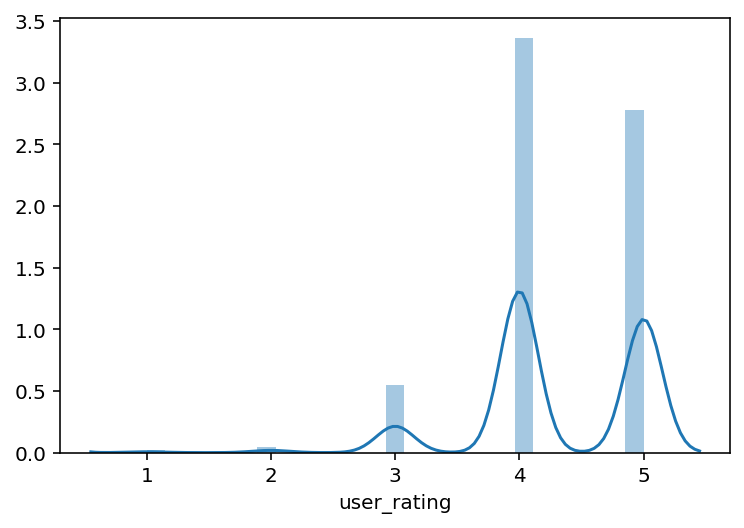

In [284]:
sns.distplot(X_train_y_train.user_rating);

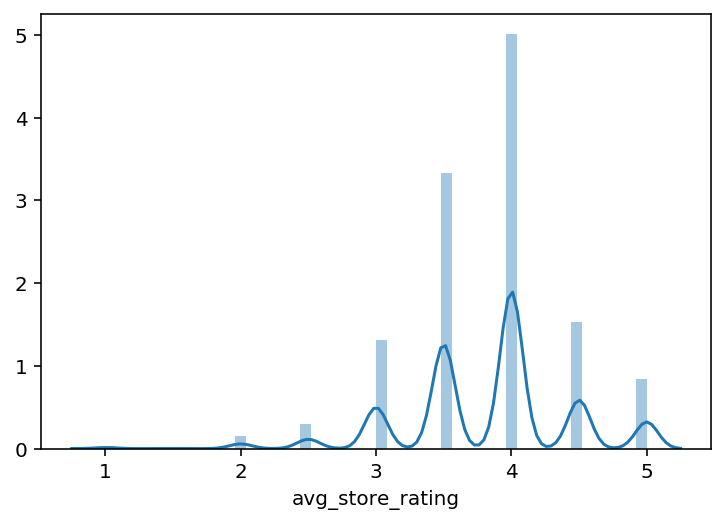

In [285]:
sns.distplot(X_train_y_train.avg_store_rating);

<ul>
    
- Avg_store_rating slightly left-skewed…

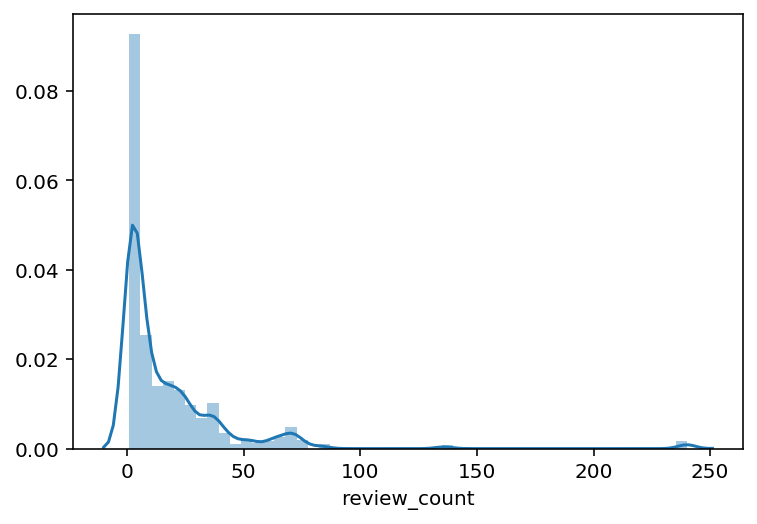

In [286]:
sns.distplot(X_train_y_train.review_count);

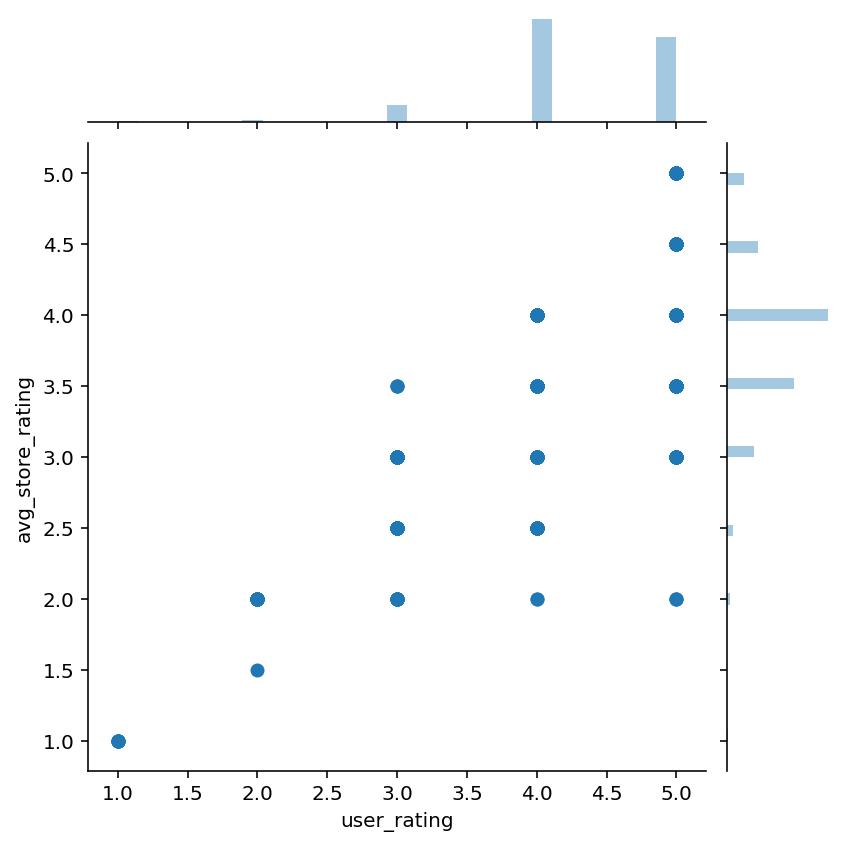

In [287]:
sns.jointplot(X_train_y_train.user_rating, X_train_y_train.avg_store_rating);

<ul>

- Some semblance of a correlation visible from the jointplot above between user_rating and avg_store_rating...

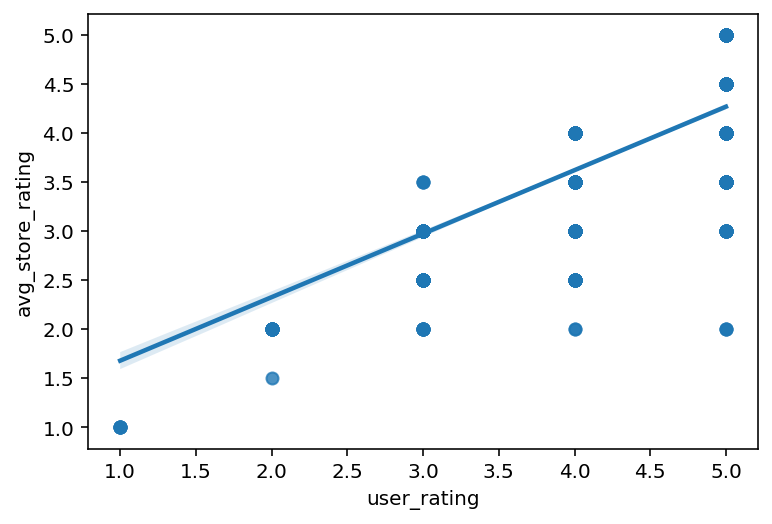

In [288]:
sns.regplot(X_train_y_train.user_rating, X_train_y_train.avg_store_rating);

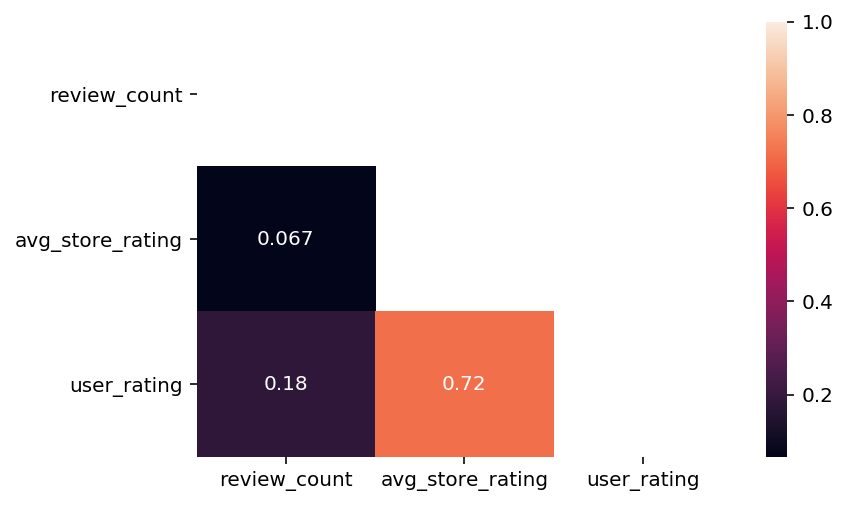

In [289]:
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(X_train_y_train[['review_count','avg_store_rating','user_rating']].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#plotting correlation heatmap
ax = sns.heatmap(X_train_y_train[['review_count','avg_store_rating','user_rating']].corr(), mask=mask, annot=True);

### Additional (optional) sneak peek at the tuning process for LogReg and DecisionTreeClassifier for Content-based Filtering
---

In [154]:
#this is a sample code of the tuning for DecisionTreeClassifier, LogReg has also been tuned in this notebook before but that code has been removed to prevent lagging up this notebook.
#more details on the modeling components in their respective sub-notebooks in the same capstone directory
#params = {
#    'max_depth':[3,5,7,10],
#    'min_samples_split':[5, 10, 15, 20],
#    'min_samples_leaf':[2, 3, 4, 5, 6, 7],
#    'class_weight':['balanced']
#    } 


#dtc_gridsearch = GridSearchCV(DecisionTreeClassifier(), params, cv = 10, verbose = 1, n_jobs = -1)
#dtc_gridsearch.fit(X_train_sc, y_train)

In [155]:
#print('Gridsearch best score: ', dtc_gridsearch.best_score_)
#print('Gridsearch best estimator: ', dtc_gridsearch.best_estimator_)
#print('Gridsearch best score on test set: ', dtc_gridsearch.best_estimator_.score(X_test_sc,y_test))

In [156]:
#saving the tuned logreg model for later use in current working directory. The saved model has been moved to ./yelp_data-part 1
#filename = 'lr_gs_model.sav'

In [157]:
#saving the tuned logreg model for later use in current working directory. The saved model has been moved to ./yelp_data-part 2
#joblib.dump(lr_gridsearch,filename)

In [158]:
#saving the tuned decisiontreeclassifier model for later use in current working directory. The saved model has been moved to ./yelp_data-part 1
#filename_1 = 'dtc_gs_model.sav'

In [159]:
#saving the tuned decisiontreeclassifier model for later use in current working directory. The saved model has been moved to ./yelp_data-part 2
#joblib.dump(dtc_gridsearch,filename_1)

<ul>
    
- Kindly note that I have also tuned LogReg and DecisionTreeClassifier models with PCA (to see if reducing the dimensionality helps in producing a better model since the 980+ shops have been dummy-coded and together with the tfidf-ed reviews, they have contributed to rather high feature dimensionality which can increase model complexity and adversely impact variance significantly) in 2 other sub-notebooks separately but both did not perform well.. Kindly take a look at those other sub-notebooks for more details. 

## Source(s)
---

- https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101
- https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada